In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as rq
import json
import math
import seaborn as sns
from scipy.interpolate import make_interp_spline
from itertools import combinations

In [120]:
user_id = 557305697713373184

In [121]:
response = rq.get('https://api.sleeper.app/v1/user/{}/leagues/nfl/2025'.format(user_id))

leagues_from_user = json.loads(response.text)

for league in leagues_from_user:
  print(league['league_id'], league['name'])

1238157874098618368 LFL
1246274844127924224 All-Pro Padrão I
1245829542220673024 League One - Fantasy Futebolista
1257435544850276352 the bummest among the bums
1235687614485364736 Loy - Redraft 2025
1238156954241601536 Blog dos Bills
1227762115771645952 Torneio Touchdown 3ª Divisão
1180984300191064064 LNF 2025 - 5ª Divisão
1209732700424896512 NGL 2 Dynasty SF
1181435308507480064 Torneio Dynasty - Liga Sul
1180525903363428352 Jeantyalha, Jeantyalha!
1257419279649734656 Loy Dynasty


In [122]:
league_id = 1238157874098618368

# **Data (from API)**

In [123]:
# team names
response = rq.get('https://api.sleeper.app/v1/league/{}/users'.format(league_id))
data = json.loads(response.text)
users_df = pd.DataFrame(data)
users_df = pd.concat([users_df, users_df["metadata"].apply(pd.Series)], axis=1)
users_df = users_df.drop(columns=users_df.columns.difference(['user_id','display_name', 'team_name']), axis=1)
users_df['team_name'] = users_df['team_name'].fillna(users_df['display_name'])
users_df

,display_name,user_id,team_name
0,NLJ,425800311060312064,NLJ
1,luccabreu23,474200398559703040,Indianapolis Foxes
2,ArtLima1,557305697713373184,Trentino Quasars
3,Vehlacys,574638254261882880,Breda SuperBowlers
4,cesar09,577300184493506560,Athens Spartans
5,GlaubinCamisa9,577300650736529408,Chattanooga CottonPickers
6,PedroParenti,577301089032908800,Dusseldorf Vetter's
7,FranciscoAbreu,577302624517263360,Utah Pombos
8,Godhawks,578381958724239360,Varzelandia Gamblers
9,BrunoBarnabe,590032723142283264,Chestnut Flyers


In [124]:
# rosters
response = rq.get('https://api.sleeper.app/v1/league/{}/rosters'.format(league_id))
data = json.loads(response.text)
rosters_df = pd.DataFrame(data)
rosters_df = pd.concat([rosters_df, rosters_df["settings"].apply(pd.Series)], axis=1)
rosters_df = rosters_df.drop(columns=rosters_df.columns.difference(['wins','roster_id', 'owner_id']), axis=1)

In [125]:
# Putting them together
teams_df = users_df.rename(columns={"user_id": "owner_id"})
teams_df = pd.merge(df_rosters, teams_df, on="owner_id")
teams_df['short_name'] = teams_df['team_name'].str.split().str[1]

In [126]:
# Weekly scores
response = rq.get('https://api.sleeper.app/v1/state/nfl')
data = json.loads(response.text)
current_week = data['week']

scores_data = []

for week in range(1, current_week):
  response = rq.get('https://api.sleeper.app/v1/league/{}/matchups/{}'.format(league_id, week))
  data = json.loads(response.text)
  for team_performance in data:
    scores_data.append({"roster_id": team_performance["roster_id"], "week": week, "points": team_performance["points"]})

scores_df = pd.DataFrame(scores_data)

In [127]:
# Weekly ranks and win probabilities
scores_df['rank'] = scores_df.groupby('week')['points'].rank(ascending=False, method='min').astype(int)
scores_df['win_prob'] = scores_df["rank"].apply(lambda x: (len(teams_df) - x) / (len(teams_df) - 1))

In [128]:
# W-L combinations
sample_list = range(1, current_week)
w_combinations = list()
for n in range(len(sample_list) + 1):
    w_combinations += list(combinations(sample_list, n))

In [129]:
# Calculating probabilities for n wins
scenarios_prob = []
for roster_id in teams_df['roster_id']:
  for scenario in w_combinations:
    wins_prob = scores_df[(scores_df['roster_id'] == roster_id) & (scores_df['week'].isin(scenario))]['win_prob'].prod() 
    losses_prob = scores_df[(scores_df['roster_id'] == roster_id) & ~scores_df['week'].isin(scenario)]['win_prob'].apply(lambda x: 1-x).prod()
    scenario_prob = wins_prob * losses_prob
    scenarios_prob.append({"roster_id": roster_id, "scenario": scenario, "n_wins": len(scenario), "prob": scenario_prob})

prob_df = pd.DataFrame(scenarios_prob) 
prob_df = prob_df.groupby(['roster_id', 'n_wins'])['prob'].sum().reset_index()

In [130]:
def expected_value(values, weights):
    values = np.asarray(values)
    weights = np.asarray(weights)
    return (values * weights).sum()

# Calculate metrics once
metrics_df = scores_df.groupby('roster_id')['points'].agg(['mean', 'std']).reset_index()
metrics_df.columns = ['roster_id', 'avg', 'std']

# Calculate expected wins
exp_w_df = prob_df.groupby('roster_id').apply(lambda g: expected_value(g['n_wins'], g['prob']))
exp_w_df = exp_w_df.reset_index()
exp_w_df.columns = ['roster_id', 'exp_w']

# Merge everything
league_df = teams_df.merge(metrics_df, on='roster_id').merge(exp_w_df, on='roster_id')
league_df["delta_w"] = league_df["exp_w"] - league_df["wins"]


/tmp/ipykernel_289231/187945391.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exp_w_df = prob_df.groupby('roster_id').apply(lambda g: expected_value(g['n_wins'], g['prob']))


# **Data Exibition**

In [131]:
league_df[['short_name', 'wins', 'exp_w', 'delta_w', 'avg', 'std']].sort_values(by='exp_w', ascending=False, ignore_index=True).round(2)

,short_name,wins,exp_w,delta_w,avg,std
0,Roludos,4,3.00,-1.00,139.45,13.75
1,Pombos,2,2.73,0.73,141.00,28.42
2,Gamblers,2,2.64,0.64,136.32,21.03
3,Quasars,2,2.36,0.36,132.50,24.87
4,Farmers,2,2.09,0.09,124.30,24.68
5,SuperBowlers,2,2.09,0.09,123.13,27.39
6,JetEagles,3,2.00,-1.00,122.78,33.60
7,Flyers,3,1.73,-1.27,119.30,19.53
8,CottonPickers,1,1.55,0.55,116.18,11.14
9,Vetter's,1,1.45,0.45,110.24,38.44


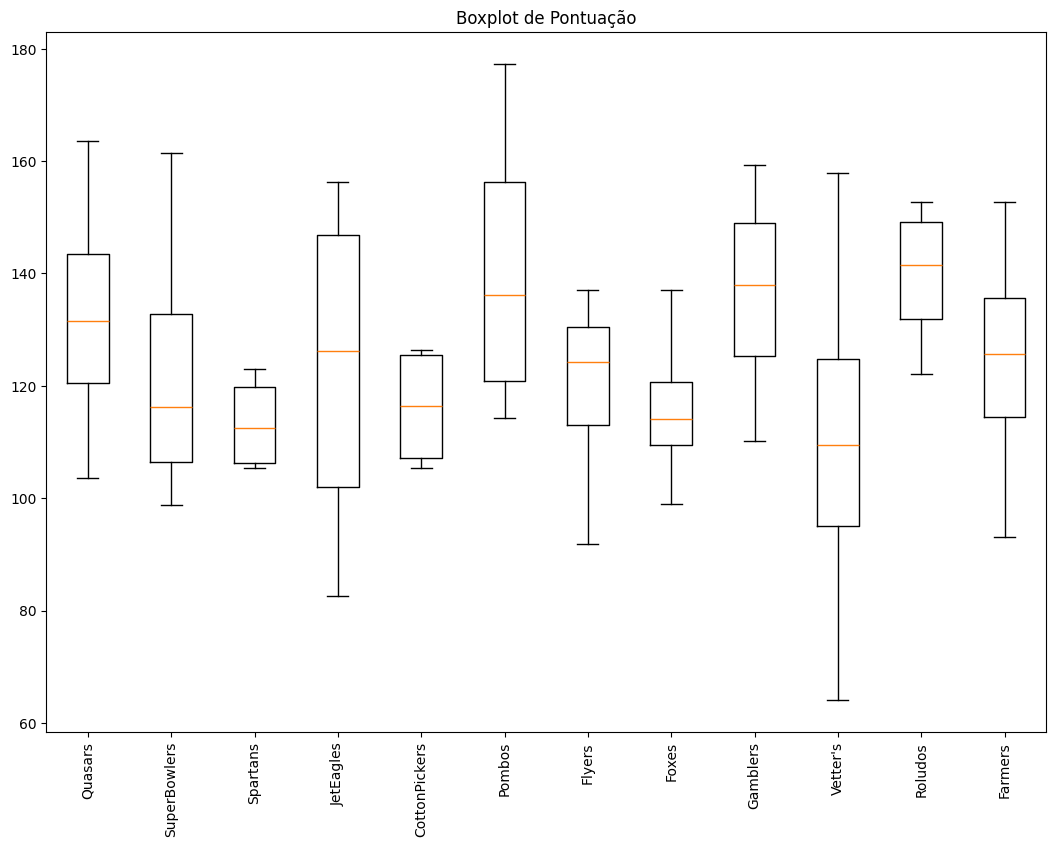

In [132]:
data = [scores_df[scores_df['roster_id'] == rid]['points'].values 
        for rid in teams_df['roster_id']]
names = league_df['short_name'].values

fig = plt.figure(figsize=(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
plt.title("Boxplot de Pontuação")
plt.xticks(range(1, len(names)+1), names, rotation=90)
plt.show()

Text(0, 0.5, 'Average Performance')

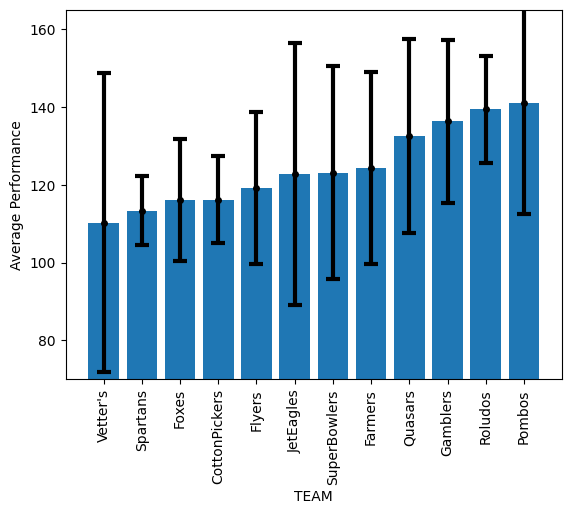

In [133]:
avg_sorted_df = league_df.sort_values(by=['avg']).reset_index(drop=True)

plt.errorbar(avg_sorted_df['short_name'], avg_sorted_df['avg'], yerr=avg_sorted_df['std'], fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1, ms=4, capsize=5)
plt.bar(avg_sorted_df['short_name'], avg_sorted_df['avg'], tick_label=avg_sorted_df['short_name'])  # Bar plot
plt.ylim((70, 165))
plt.xlabel('TEAM')  # Label on X axis
plt.xticks(rotation=90)
plt.ylabel('Average Performance')  # Label on Y axis

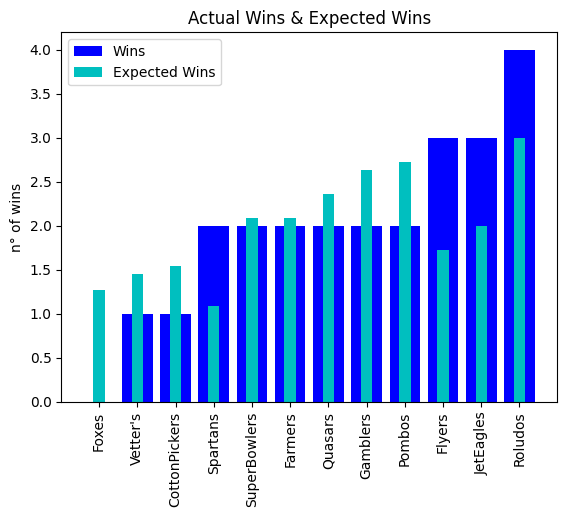

In [134]:
exp_w_sorted_df = league_df.sort_values(by=['wins', 'exp_w'])
exp_w_sorted_df = exp_w_sorted_df.reset_index(drop=True)

fig, ax = plt.subplots()

ax.bar(exp_w_sorted_df['short_name'], exp_w_sorted_df['wins'], 0.8, label='Wins', color='b')
ax.bar(exp_w_sorted_df['short_name'], exp_w_sorted_df['exp_w'], 0.3, label='Expected Wins', color='c')

ax.set_ylabel('n° of wins')
ax.set_title('Actual Wins & Expected Wins')
ax.legend()

plt.xticks(rotation=90)

plt.show()

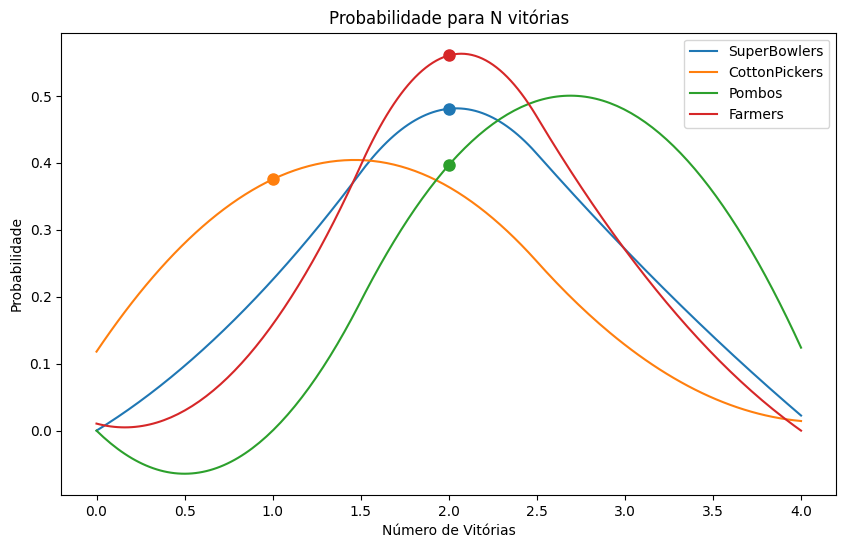

In [135]:
# Define the team names to display (use short names or full names)
team_names = ["SuperBowlers", "CottonPickers", "Pombos", "Farmers"]

# Plot setup
plt.figure(figsize=(10, 6))

# Iterate over each specified team
for short_name in team_names:
    # Get roster_id for this team
    team_data = teams_df[teams_df['short_name'] == short_name]
    if team_data.empty:
        continue
    
    roster_id = team_data['roster_id'].values[0]
    wins = team_data['wins'].values[0]
    
    # Get probability data for this team
    team_prob = prob_df[prob_df['roster_id'] == roster_id].sort_values('n_wins')
    x_original = team_prob['n_wins'].values
    data = team_prob['prob'].values
    
    # Create a smooth x range for interpolation
    x_smooth = np.linspace(x_original.min(), x_original.max(), 200)
    
    # Create a cubic spline interpolation
    spline = make_interp_spline(x_original, data, k=2)
    y_smooth = spline(x_smooth)
    
    # Plot the smoothed curve
    line, = plt.plot(x_smooth, y_smooth, label=short_name)
    
    # Add a circle marker at the actual wins position
    y_wins = spline(wins)
    plt.plot(wins, y_wins, 'o', color=line.get_color(), markersize=8)

# Final plot adjustments
plt.title("Probabilidade para N vitórias")
plt.xlabel("Número de Vitórias")
plt.ylabel("Probabilidade")
plt.legend()
plt.show()

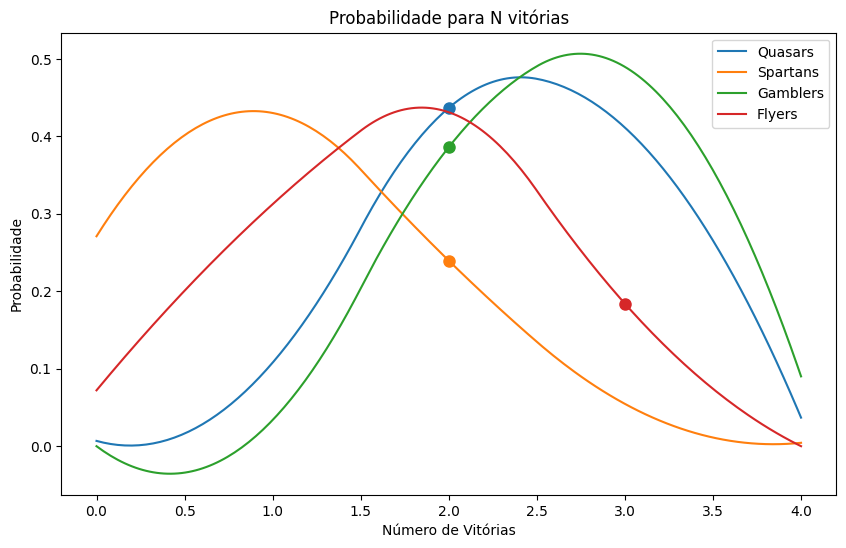

In [136]:
# Define the team names to display (use short names or full names)
team_names = ["Quasars", "Spartans", "Gamblers", "Flyers"]

# Plot setup
plt.figure(figsize=(10, 6))

# Iterate over each specified team
for short_name in team_names:
    # Get roster_id for this team
    team_data = teams_df[teams_df['short_name'] == short_name]
    if team_data.empty:
        continue
    
    roster_id = team_data['roster_id'].values[0]
    wins = team_data['wins'].values[0]
    
    # Get probability data for this team
    team_prob = prob_df[prob_df['roster_id'] == roster_id].sort_values('n_wins')
    x_original = team_prob['n_wins'].values
    data = team_prob['prob'].values
    
    # Create a smooth x range for interpolation
    x_smooth = np.linspace(x_original.min(), x_original.max(), 200)
    
    # Create a cubic spline interpolation
    spline = make_interp_spline(x_original, data, k=2)
    y_smooth = spline(x_smooth)
    
    # Plot the smoothed curve
    line, = plt.plot(x_smooth, y_smooth, label=short_name)
    
    # Add a circle marker at the actual wins position
    y_wins = spline(wins)
    plt.plot(wins, y_wins, 'o', color=line.get_color(), markersize=8)

# Final plot adjustments
plt.title("Probabilidade para N vitórias")
plt.xlabel("Número de Vitórias")
plt.ylabel("Probabilidade")
plt.legend()
plt.show()

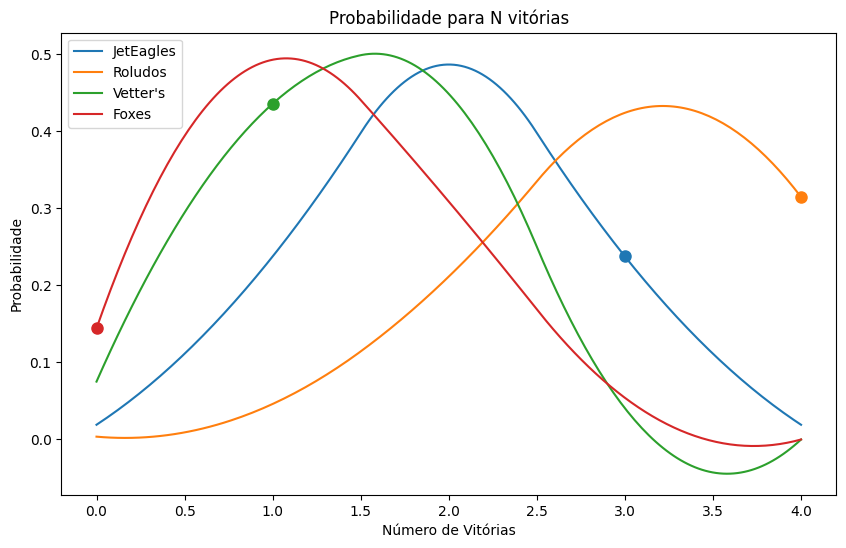

In [137]:
# Define the team names to display (use short names or full names)
team_names = ["JetEagles", "Roludos", "Vetter's", "Foxes"]

# Plot setup
plt.figure(figsize=(10, 6))

# Iterate over each specified team
for short_name in team_names:
    # Get roster_id for this team
    team_data = teams_df[teams_df['short_name'] == short_name]
    if team_data.empty:
        continue
    
    roster_id = team_data['roster_id'].values[0]
    wins = team_data['wins'].values[0]
    
    # Get probability data for this team
    team_prob = prob_df[prob_df['roster_id'] == roster_id].sort_values('n_wins')
    x_original = team_prob['n_wins'].values
    data = team_prob['prob'].values
    
    # Create a smooth x range for interpolation
    x_smooth = np.linspace(x_original.min(), x_original.max(), 200)
    
    # Create a cubic spline interpolation
    spline = make_interp_spline(x_original, data, k=2)
    y_smooth = spline(x_smooth)
    
    # Plot the smoothed curve
    line, = plt.plot(x_smooth, y_smooth, label=short_name)
    
    # Add a circle marker at the actual wins position
    y_wins = spline(wins)
    plt.plot(wins, y_wins, 'o', color=line.get_color(), markersize=8)

# Final plot adjustments
plt.title("Probabilidade para N vitórias")
plt.xlabel("Número de Vitórias")
plt.ylabel("Probabilidade")
plt.legend()
plt.show()

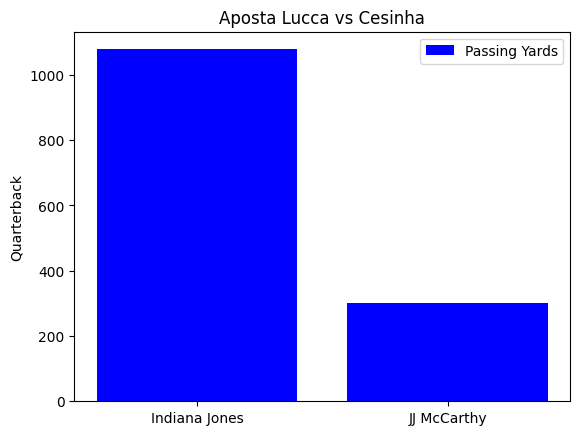

In [138]:
qb_data = {'QB': ["Indiana Jones", "JJ McCarthy"], 'PassingYards': [1078, 301]}
df_qb = pd.DataFrame(data=qb_data)

fig, ax = plt.subplots()

ax.bar(df_qb['QB'], df_qb['PassingYards'], 0.8, label='Passing Yards', color = 'b')

ax.set_ylabel("Quarterback")
ax.set_title('Aposta Lucca vs Cesinha')
ax.legend()


plt.show()